# Part 1: Predictive Task

1. The goal of this task is to **recommend the beauty products a user is most likely to interact with** based on their past interactions and review text. 
This is a **Top-K (ranking based) recommendation task** where the target is a ranked list of items. 

--- 
2. We will evaluate this model using:
- Precision @K
    - Measures the fraction of recommended items that actually appeared in the user’s held-out test set.
    - Example: if we recommend 10 products and 2 are correct → Precision@10 = 0.20.
    - Precision@K is appropriate because it captures the proportion of correct recommendations among the Top-K returned items. It is proportionate to Hit Rate and as a result
    Precision@K measures ranking quality more directly by quantifying how many of the recommended items were relevant to the user.

3. Relevant baselines for comparison can include:
    - **Popularity baseline**
        - Rank items based on their popularity, and return the top K most popular items 100% of the time, regardless of user
        - Not really a "true" recommendation task. Doesn't capture user and item relationships.
        - Decent baseline, but not great performance generally
        - Naive implementation: Thought ptocess assumes that users will buy the most popular product all the time
    
--- 
4. Model validity is pretty straightforward here:
    - The more information we have about a user, the better their recommendations should be (basis of a good recommender system)
    - The model is generalizable; testing with a test set proves that the model is not overfitting in any way

# Part 2: Exploratory Data Analysis

## 1. Context - Dataset Overview

We use the **Amazon Reviews 2023 dataset** from McAuley Lab at UCSD, specifically the **Beauty and Personal Care** category. This large-scale dataset contains 571.54 million reviews across 48.19 million items from 54.51 million users, spanning May 1996 to September 2023.

**What's included:** User reviews (ratings, text, helpful votes, timestamps), item metadata (descriptions, titles, prices), and user-item interaction graphs.

**Our subset:** We sampled ~700K reviews from the Beauty category to balance computational constraints with dataset diversity.

**Citation:** Hou, Y., Li, J., He, Z., Yan, A., Chen, X., & McAuley, J. (2024). 
Bridging Language and Items for Retrieval and Recommendation. 
arXiv preprint arXiv:2403.03952.

---

## 2. Discussion - Data Processing

**Key preprocessing steps:**
- Dropped rows with missing critical fields (user_id, parent_asin, rating)
- Created text_length (word count),  year (from timestamp), and combined_text (title + review) features
- **Different filtering for different models:**
  - TF-IDF and Jaccard: Users with 2+ reviews (150K sample)
  - NCF: Users with 30+ reviews (dense data for neural network)
  - Popularity: Full 300K sample (no filtering)

**Main challenge:** **92.3% of users have only 1 review** - extreme sparsity that hurts collaborative filtering.

---

## 3. Key Findings

### Rating Distribution
- **58% are 5-star reviews** (420,726 out of 700K)
- Heavy positive bias is typical for online reviews
- Distribution stable over time

### Review Text
- Most reviews are short (<20 words)
- **Middle ratings (2-4) have longest reviews** (~35-40 words) - users write more when they have mixed feelings
- Sufficient text for TF-IDF similarity

### Temporal Trends
- Reviews peaked in 2020-2021 (COVID-19 online shopping surge)
- Most data from 2015-2021 - reflects current beauty trends

### Sparsity Statistics
631,986 unique users
115,709 unique products
Avg reviews per user: 1.11
Avg reviews per product: 6.06

Users with only 1 review: 583,353 (92.3%)
Products with only 1 review: 48,859 (42.2%)

**Implications:**
- Collaborative filtering will struggle (need user overlap)
- Content-based approaches essential
- Popularity baseline will be strong
- NCF needs dense user filtering

### Feature Correlations
- Rating vs text_length: -0.02 (no correlation)
- text_length vs helpful_vote: +0.18 (longer reviews slightly more helpful)
- Features are largely independent

---

## Summary

**Strengths:** Large dataset, rich text, recent data

**Challenges:** Extreme user sparsity (92% single-review users), cold start for niche products

**Impact:** CF models need user filtering, content-based approaches are essential, need stratified evaluation by user density

In [6]:
import json, gzip
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
i = 0
file = "All_Beauty.jsonl.gz"
reviews = []
with gzip.open(file, "rt", encoding="utf-8") as fp:
    for i, line in enumerate(fp):
        reviews.append(json.loads(line))
df = pd.DataFrame(reviews)
df.head()
print(f"Loaded {len(df):,} reviews")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

Loaded 701,528 reviews

Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Data types:
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
user_id               object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object

Missing values:
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

Rating distribution:
rating
1.0    102080
2.0     43034
3.0     56307
4.0     79381
5.0    420726
Name: count, dtype: int64


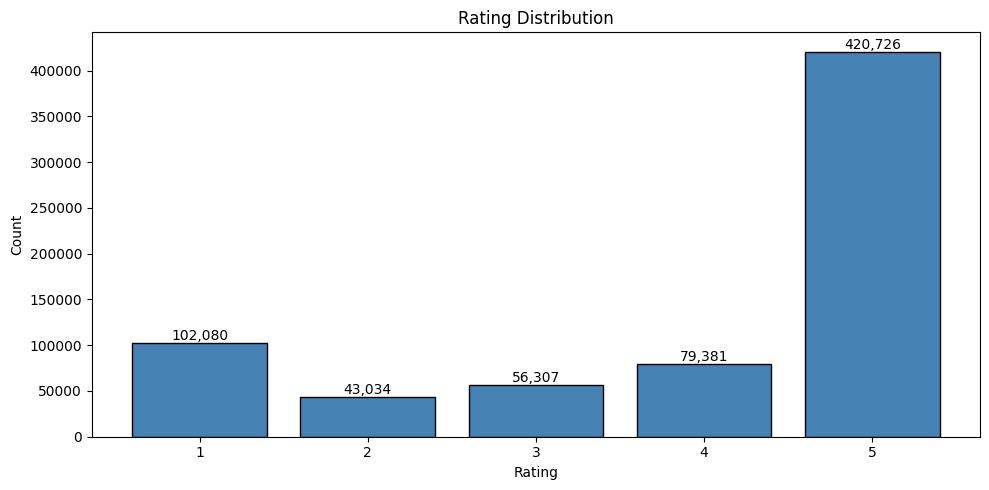

First 100k reviews:
rating
1.0    0.11042
2.0    0.06135
3.0    0.09093
4.0    0.13156
5.0    0.60574
Name: proportion, dtype: float64

Last 100k reviews:
rating
1.0    0.19621
2.0    0.05955
3.0    0.06641
4.0    0.09757
5.0    0.58026
Name: proportion, dtype: float64


In [7]:
plt.figure(figsize=(10, 5))
rating_counts = df['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
for i, v in zip(rating_counts.index, rating_counts.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


print("First 100k reviews:")
df_early = pd.DataFrame(reviews[:100000])
print(df_early['rating'].value_counts(normalize=True).sort_index())

print("\nLast 100k reviews:")
df_late = pd.DataFrame(reviews[-100000:])
print(df_late['rating'].value_counts(normalize=True).sort_index())


Review length stats (words):
count    701528.000000
mean         32.750720
std          45.973273
min           0.000000
25%           8.000000
50%          19.000000
75%          40.000000
max        2585.000000
Name: text_length, dtype: float64


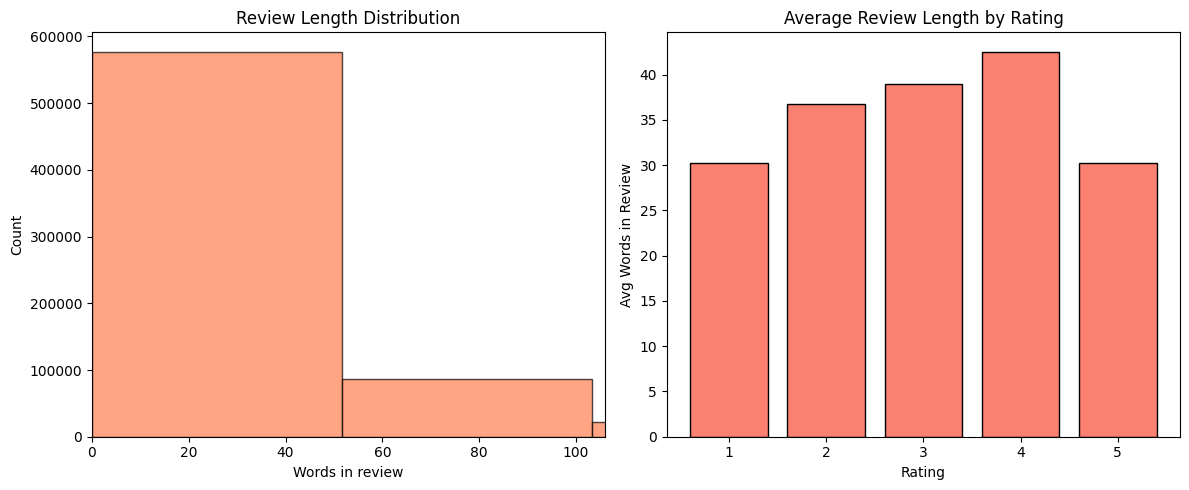


631,986 unique users
115,709 unique products
Avg reviews per user: 1.11
Avg reviews per product: 6.06

Users with only 1 review: 583,553 (92.3%)
Products with only 1 review: 48,859 (42.2%)

Top 10 most reviewed products:
asin
B007IAE5WY    1962
B00EEN2HCS    1750
B07C533XCW    1513
B00R1TAN7I    1372
B08L5KN7X4    1343
B019GBG0IE    1328
B0719KWG8H    1168
B0092MCQZ4    1128
B0107QYW14    1112
B0070Z7KME     934
Name: count, dtype: int64

Reviews by year:
year
2000         1
2001        12
2002        24
2003        56
2004       134
2005       267
2006       419
2007      1162
2008      1269
2009      1207
2010      1586
2011      1877
2012      2803
2013      7948
2014     16279
2015     36239
2016     62747
2017     68035
2018     72707
2019     99120
2020    126753
2021    124897
2022     61581
2023     14405
Name: count, dtype: int64


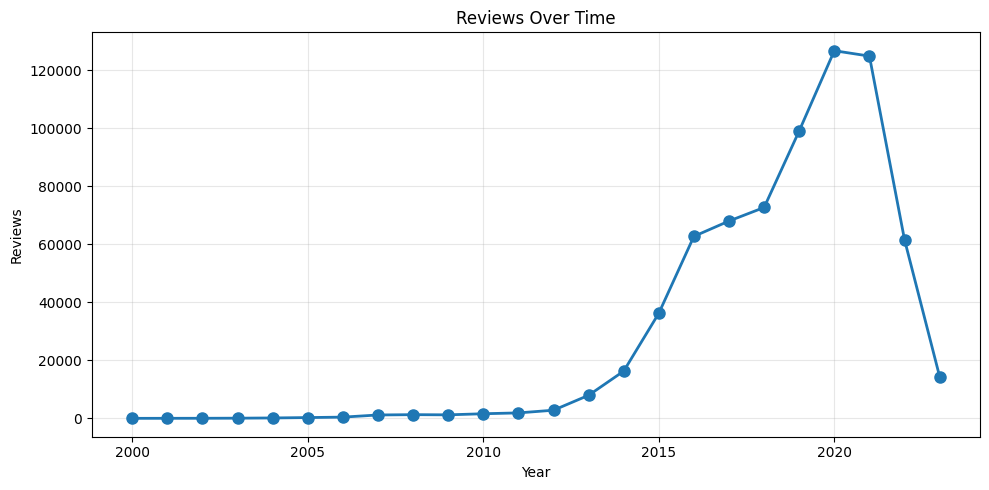


Helpful votes by rating:
rating
1.0    0.96
2.0    0.75
3.0    0.73
4.0    0.93
5.0    0.96
Name: helpful_vote, dtype: float64


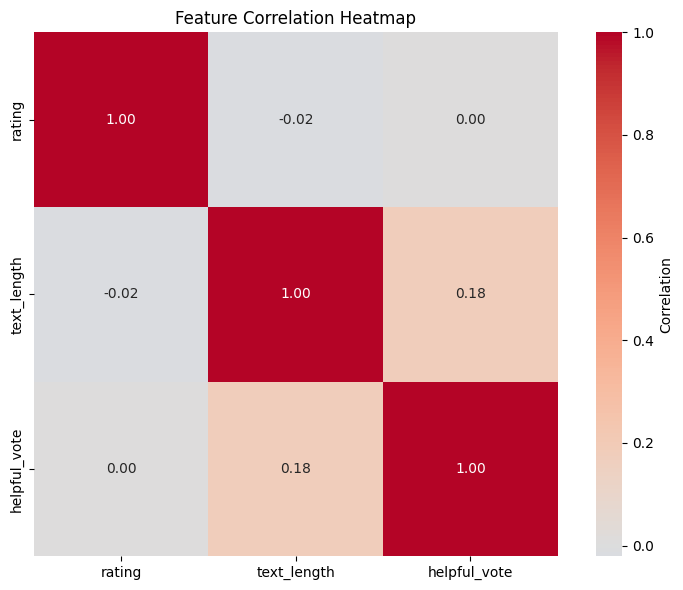

In [8]:
# Review text analysis
df['text_length'] = df['text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
print(f"\nReview length stats (words):\n{df['text_length'].describe()}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Words in review')
plt.ylabel('Count')
plt.title('Review Length Distribution')
plt.xlim(0, df['text_length'].quantile(0.95))

plt.subplot(1, 2, 2)
avg_length_by_rating = df.groupby('rating')['text_length'].mean()
plt.bar(avg_length_by_rating.index, avg_length_by_rating.values, color='salmon', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Avg Words in Review')
plt.title('Average Review Length by Rating')

plt.tight_layout()
plt.show()

# User and product statistics
n_users = df['user_id'].nunique()
n_products = df['asin'].nunique()

print(f"\n{n_users:,} unique users")
print(f"{n_products:,} unique products")
print(f"Avg reviews per user: {len(df)/n_users:.2f}")
print(f"Avg reviews per product: {len(df)/n_products:.2f}")

# Sparsity analysis
user_counts = df['user_id'].value_counts()
product_counts = df['asin'].value_counts()

print(f"\nUsers with only 1 review: {(user_counts == 1).sum():,} ({(user_counts == 1).sum()/n_users*100:.1f}%)")
print(f"Products with only 1 review: {(product_counts == 1).sum():,} ({(product_counts == 1).sum()/n_products*100:.1f}%)")

print(f"\nTop 10 most reviewed products:")
print(product_counts.head(10))

# Temporal trends
if 'timestamp' in df.columns:
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['year'] = df['date'].dt.year
    
    yearly = df['year'].value_counts().sort_index()
    print(f"\nReviews by year:")
    print(yearly)
    
    plt.figure(figsize=(10, 5))
    plt.plot(yearly.index, yearly.values, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Year')
    plt.ylabel('Reviews')
    plt.title('Reviews Over Time')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Helpfulness
if 'helpful_vote' in df.columns:
    print(f"\nHelpful votes by rating:")
    print(df.groupby('rating')['helpful_vote'].mean().round(2))

# Correlation heatmap
numeric_cols = ['rating', 'text_length']
if 'helpful_vote' in df.columns:
    numeric_cols.append('helpful_vote')

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Part 3: Modeling

## Context

### ML Problem Formulation

**Inputs:** User ID + their historical purchases (set of product ASINs)

**Outputs:** Ranked list of 10 product ASINs the user is most likely to purchase next

**What's being optimized:** We want to maximize the overlap between our Top-10 recommendations and what users actually bought in the test set. We're learning patterns from user-item interactions (and item text) to predict future purchases.

---
## Discussion 

### Models Implemented

We built four models with increasing complexity:

### 1. Popularity Baseline
**How it works:** Count each product's total purchases in training data, recommend the same Top-10 globally popular items to everyone.

**Advantages:**
- Simple - Just always return the most popular item based on review counts
- No training time
- Surprisingly effective
- Fast inference (same list for everyone)
- Super easy to code

**Disadvantages:**
- Zero personalization
- Can't capture individual taste
- Ignores user history completely
- Misses kind of the whole point of recommendation tasks - tailoring to individuals

### 2. TF-IDF Content-Based Filtering
**How it works:** Build TF-IDF vectors (bag of words) from item text (title + reviews), compute cosine similarity between items. For each user, find items similar to what they've purchased.

**Advantages:**
- Uses actual product content (titles, descriptions)
- Works even for items with no purchase history
- Interpretable - recommendations are "textually similar"
- No need for user overlap
- Wonderful for sparse datasets

**Neutral**
- A bit more difficult to implement relative to Jaccard or popularity baseline, but still relatively straightforward

**Disadvantages:**
- Limited to text similarity (can't capture latent preferences)
- Requires decent text data per item, otherwise ineffective
- High-dimensional TF-IDF matrix (5000 features, memory constraints)
- Doesn't learn from collaborative patterns

**Implementation:** We combined title + review text per item, built a 5000-feature TF-IDF matrix, and aggregated similarity scores across each user's purchase history.

### 3. Jaccard Collaborative Filtering
**How it works:** For each item a user bought, find similar items based on user co-purchase patterns. Items with high Jaccard similarity (intersection/union of user sets) get recommended.

**Advantages:**
- Classic item-item collaborative filtering from class material (HW2)
- Interpretable - "users who bought X also bought Y", so X and Y share some similarity
- Captures collaborative patterns
- Very easy to write code for implementation is easy

**Disadvantages:**
- **Requires user overlap** - struggles significantly with sparse data
- Computationally expensive (nested loops over items)
- Cold start problem for new items/users. Can either 1. filter for users who have more than 1 review (our solution) or 2. revert back to popularity.

**Implementation:** We built user_items (user → set of purchases) and item_users (item → set of purchasers) dictionaries. For each user's purchased items, we compute Jaccard similarity to all candidate items and aggregate scores.

### 4. Neural Collaborative Filtering (NCF) with Text Embeddings
**How it works:** Learn user and item embeddings through a neural network trained with Bayesian Personalized Ranking (BPR) loss. Augment item embeddings with pre-trained text embeddings from Sentence-BERT. This is a deep learning method we implemented for fun, to see if it can outperform the models we implemented in the first few assignments.

**Model architecture:**
- User embedding: 64 dimensions
- Item embedding: 64 dimensions  
- Text embedding: 384 dimensions (MiniLM) projected to 64
- MLP: [128 → 64 → 1] with ReLU activations

**Training:** BPR loss maximizes the score gap between positive items (purchased) and negative items (not purchased).

**Advantages:**
- Learns latent representations beyond text/co-purchase patterns
- Combines collaborative + content signals
- Can capture complex non-linear relationships
- State-of-the-art approach for implicit feedback

**Disadvantages:**
- Requires GPU and substantial training time
- Black box - hard to interpret embeddings
- Needs hyperparameter tuning (embedding dim, learning rate, etc.)
- Risk of overfitting on small datasets
- Difficult to write code for, requires deep learning knowledge

**Implementation:** We filtered to users with 30+ reviews to ensure dense data. Used Sentence-BERT to encode item text, trained for 3 epochs with BPR loss and negative sampling.

All four models are appropriate for ranking-based recommendation because they each produce relevance scores that can be sorted to generate Top-K lists:

- **Popularity:** Ranks by purchase frequency
- **TF-IDF:** Ranks by text similarity scores  
- **Jaccard:** Ranks by collaborative similarity scores
- **NCF:** Ranks by learned preference scores from the neural network

Each model takes a different approach to the same fundamental task - predicting which items a user will interact with - allowing us to compare collaborative filtering, content-based filtering, and deep learning approaches on the same evaluation metric (Precision@10).


In [9]:
import json
import gzip
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from collections import Counter
min_reviews_per_user = 2
user_counts = df['user_id'].value_counts()
valid_users = user_counts[user_counts >= min_reviews_per_user].index
df_filtered = df[df['user_id'].isin(valid_users)]
df_filtered = df_filtered.head(150000)
print(f"Filtered dataset: {len(df_filtered)} reviews, {len(valid_users)} users")
for col in ['text', 'title', 'parent_asin']:
    if col not in df_filtered.columns:
        df_filtered[col] = ''
    df_filtered[col] = df_filtered[col].fillna('')
df_filtered['combined_text'] = df_filtered['text'] + ' ' + df_filtered['title'] + ' ' + df_filtered['parent_asin']

# -------------------------------
# Split train/test
# -------------------------------
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

# -------------------------------
# Build item TF-IDF matrix
# -------------------------------
item_texts = train_df.groupby('asin')['combined_text'].apply(lambda x: " ".join(x))
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(item_texts)
asins = list(item_texts.index)
asin_to_index = {asin: idx for idx, asin in enumerate(asins)}

# -------------------------------
# Popularity baseline
# -------------------------------
popular_items = train_df['asin'].value_counts().index.tolist()
def recommend_popular(top_k=10):
    return popular_items[:top_k]

# -------------------------------
# TF-IDF recommendation
# -------------------------------
def recommend_for_user(user_id, top_k=10):
    user_items = train_df[train_df['user_id'] == user_id]['asin'].unique()
    if len(user_items) == 0:
        return []

    sim_scores = np.zeros(len(asins))
    for asin in user_items:
        if asin in asin_to_index:
            vec = tfidf_matrix[asin_to_index[asin]]
            sims = cosine_similarity(vec, tfidf_matrix).flatten()
            sim_scores += sims

    # Remove already seen items
    seen_idx = [asin_to_index[asin] for asin in user_items if asin in asin_to_index]
    sim_scores[seen_idx] = 0

    top_idx = np.argsort(sim_scores)[::-1][:top_k]
    return [asins[i] for i in top_idx]

# -------------------------------
# Precision@10 evaluation
# -------------------------------
def precision_at_k(user_id, top_k=10):
    true_items = test_df[test_df['user_id'] == user_id]['asin'].unique()
    if len(true_items) == 0:
        return None
    recommended = recommend_for_user(user_id, top_k)
    hits = len(set(recommended) & set(true_items))
    return hits / top_k

def precision_at_k_baseline(user_id, top_k=10):
    true_items = test_df[test_df['user_id'] == user_id]['asin'].unique()
    if len(true_items) == 0:
        return None
    recommended = recommend_popular(top_k)
    hits = len(set(recommended) & set(true_items))
    return hits / top_k

# -------------------------------
# Compute average Precision@10
# -------------------------------
test_users = test_df['user_id'].unique()
tfidf_precisions = []
baseline_precisions = []

for i, user in enumerate(test_users):
    if i % 100 == 0:
        print(f"Evaluating user {i}/{len(test_users)}")
    p = precision_at_k(user, top_k=10)
    if p is not None:
        tfidf_precisions.append(p)
    b = precision_at_k_baseline(user, top_k=10)
    if b is not None:
        baseline_precisions.append(b)

print("Average Precision@10 (TF-IDF):", np.mean(tfidf_precisions))
print("Average Precision@10 (Popularity Baseline):", np.mean(baseline_precisions))

# -------------------------------
# Example top-10 recommendation
# -------------------------------
example_user = test_users[0]
print(f"Top 10 TF-IDF recommendations for user {example_user}: {recommend_for_user(example_user, 10)}")
print(f"Top 10 Popular items (baseline): {recommend_popular(10)}")

Filtered dataset: 117975 reviews, 48433 users
Train: 94380, Test: 23595
Evaluating user 0/19276
Evaluating user 100/19276
Evaluating user 200/19276
Evaluating user 300/19276
Evaluating user 400/19276
Evaluating user 500/19276
Evaluating user 600/19276
Evaluating user 700/19276
Evaluating user 800/19276
Evaluating user 900/19276
Evaluating user 1000/19276
Evaluating user 1100/19276
Evaluating user 1200/19276
Evaluating user 1300/19276
Evaluating user 1400/19276
Evaluating user 1500/19276
Evaluating user 1600/19276
Evaluating user 1700/19276
Evaluating user 1800/19276
Evaluating user 1900/19276
Evaluating user 2000/19276
Evaluating user 2100/19276
Evaluating user 2200/19276
Evaluating user 2300/19276
Evaluating user 2400/19276
Evaluating user 2500/19276
Evaluating user 2600/19276
Evaluating user 2700/19276
Evaluating user 2800/19276
Evaluating user 2900/19276
Evaluating user 3000/19276
Evaluating user 3100/19276
Evaluating user 3200/19276
Evaluating user 3300/19276
Evaluating user 3400/1

In [10]:
# -------------------------------
# Jaccard Collaborative Filtering
# -------------------------------

from collections import defaultdict

print("Building user->items and item->users maps...")

# user -> items they've interacted with
user_items = defaultdict(set)
# item -> users who've interacted with it
item_users = defaultdict(set)

for row in train_df[['user_id','asin']].itertuples(index=False):
    user_items[row.user_id].add(row.asin)
    item_users[row.asin].add(row.user_id)

print("Maps built:")
print(f"Users in training: {len(user_items)}")
print(f"Items in training: {len(item_users)}")

# -------------------------------
# Recommend with Jaccard
# -------------------------------
def recommend_jaccard(user_id, top_k=10):
    seen_items = user_items[user_id]
    scores = Counter()

    # For every item the user has seen
    for item in seen_items:
        users_for_item = item_users[item]

        # Compare to other candidate items
        for candidate_item, candidate_users in item_users.items():
            if candidate_item in seen_items:
                continue
            
            # Jaccard similarity
            intersection = len(users_for_item & candidate_users)
            union = len(users_for_item | candidate_users)

            if union > 0:
                scores[candidate_item] += intersection / union

    return [item for item, score in scores.most_common(top_k)]

# -------------------------------
# Precision@10 for Jaccard
# -------------------------------
def precision_at_k_jaccard(user_id, top_k=10):
    true_items = set(test_df[test_df['user_id'] == user_id]['asin'].unique())
    if len(true_items) == 0:
        return None

    recommended = recommend_jaccard(user_id, top_k)
    hits = len(set(recommended) & true_items)
    return hits / top_k

# -------------------------------
# Compute average Precision@10 (Jaccard)
# -------------------------------
print("Evaluating Jaccard...")

jaccard_precisions = []

for i, user in enumerate(test_users):
    if i % 100 == 0:
        print(f"Evaluating user {i}/{len(test_users)}")

    if user in user_items:
        p_j = precision_at_k_jaccard(user, top_k=10)
        if p_j is not None:
            jaccard_precisions.append(p_j)

print("Average Precision@10 (Jaccard):", np.mean(jaccard_precisions))

# -------------------------------
# Example Jaccard recommendation
# -------------------------------
example_user = test_users[0]
print(f"Top 10 Jaccard recommendations for user {example_user}: {recommend_jaccard(example_user, 10)}")

Building user->items and item->users maps...
Maps built:
Users in training: 46803
Items in training: 40627
Evaluating Jaccard...
Evaluating user 0/19276
Evaluating user 100/19276
Evaluating user 200/19276
Evaluating user 300/19276
Evaluating user 400/19276
Evaluating user 500/19276
Evaluating user 600/19276
Evaluating user 700/19276
Evaluating user 800/19276
Evaluating user 900/19276
Evaluating user 1000/19276
Evaluating user 1100/19276
Evaluating user 1200/19276
Evaluating user 1300/19276
Evaluating user 1400/19276
Evaluating user 1500/19276
Evaluating user 1600/19276
Evaluating user 1700/19276
Evaluating user 1800/19276
Evaluating user 1900/19276
Evaluating user 2000/19276
Evaluating user 2100/19276
Evaluating user 2200/19276
Evaluating user 2300/19276
Evaluating user 2400/19276
Evaluating user 2500/19276
Evaluating user 2600/19276
Evaluating user 2700/19276
Evaluating user 2800/19276
Evaluating user 2900/19276
Evaluating user 3000/19276
Evaluating user 3100/19276
Evaluating user 320

In [ ]:
# %%
# --------------------
# Neural Collaborative Filtering (NCF) on 20k samples
# --------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# --------------------
# 1. Sample 20k reviews and split
# --------------------
SAMPLE_N = 20000
df_sample = df.sample(n=min(SAMPLE_N, len(df)), random_state=42)

train_val, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val, test_size=0.2, random_state=42)

# Encode users and items
user_le = LabelEncoder()
item_le = LabelEncoder()
user_le.fit(train_df['user_id'].astype(str))
item_le.fit(train_df['asin'].astype(str))

def encode_safe(le, series):
    mapping = {v: i+1 for i, v in enumerate(le.classes_)}
    return series.map(mapping).fillna(0).astype(int)

for d in [train_df, val_df, test_df]:
    d['user_idx'] = encode_safe(user_le, d['user_id'])
    d['item_idx'] = encode_safe(item_le, d['asin'])

N_USERS = len(user_le.classes_) + 1
N_ITEMS = len(item_le.classes_) + 1

# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
# --------------------
# 1. Filter users with > 30 reviews
# --------------------
user_counts = df.groupby('user_id').size()
valid_users = user_counts[user_counts > 30].index

df_filtered = df[df['user_id'].isin(valid_users)].copy()

print("Filtered rows:", len(df_filtered))
print("Filtered unique users:", df_filtered['user_id'].nunique())
print("Filtered unique items:", df_filtered['asin'].nunique())

# Split after filtering
train_val, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val, test_size=0.2, random_state=42)

# %%
user_le = LabelEncoder()
item_le = LabelEncoder()

user_le.fit(train_df['user_id'].astype(str))
item_le.fit(train_df['asin'].astype(str))

def encode_safe(le, series):
    mapping = {v: i+1 for i, v in enumerate(le.classes_)}
    return series.map(mapping).fillna(0).astype(int)

for d in [train_df, val_df, test_df]:
    d['user_idx'] = encode_safe(user_le, d['user_id'])
    d['item_idx'] = encode_safe(item_le, d['asin'])

# %%
N_USERS = len(user_le.classes_) + 1
N_ITEMS = len(item_le.classes_) + 1

# %%
# --------------------
# 2. Text embeddings (optional)
# --------------------
from sentence_transformers import SentenceTransformer

USE_TEXT = True
TEXT_EMB_DIM = 384  # MiniLM default

if USE_TEXT:
    text_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Build a single text per item (title + text)
    item_texts = {}
    for asin, group in train_df.groupby('asin'):
        title = group['title'].dropna().astype(str)
        body  = group['text'].dropna().astype(str)  # FIXED: your dataset uses 'text'

        parts = []
        if len(title): parts.append(title.iloc[0])
        if len(body):  parts.append(body.iloc[0])

        item_texts[asin] = " ".join(parts) if parts else ""

    # Build ordered list matching item_le classes
    ordered_texts = []
    for idx in range(1, N_ITEMS):
        asin = item_le.inverse_transform([idx-1])[0]
        ordered_texts.append(item_texts.get(asin, ""))

    # Compute embeddings
    embeddings = text_model.encode(ordered_texts, convert_to_numpy=True)

    # Add 0-vector for padding index 0
    item_text_matrix = torch.tensor(
        np.vstack([np.zeros((1, embeddings.shape[1])), embeddings]),
        dtype=torch.float32
    )

else:
    item_text_matrix = None


# %%
# --------------------
# 3. Proper BPR Dataset with safe negative sampling
# --------------------
from collections import defaultdict

class BPRDataset(Dataset):
    def __init__(self, df, n_items):
        self.user_idx = df['user_idx'].values
        self.item_idx = df['item_idx'].values
        self.n_items = n_items

        # Build user → set of positives (needed for real negative sampling)
        self.user_pos = defaultdict(set)
        for u, i in zip(self.user_idx, self.item_idx):
            self.user_pos[u].add(i)

    def __len__(self):
        return len(self.user_idx)

    def __getitem__(self, idx):
        u = self.user_idx[idx]
        i = self.item_idx[idx]

        # sample a negative that user never interacted with
        j = np.random.randint(1, self.n_items)
        while j in self.user_pos[u]:
            j = np.random.randint(1, self.n_items)

        return (
            torch.tensor(u, dtype=torch.long),
            torch.tensor(i, dtype=torch.long),
            torch.tensor(j, dtype=torch.long),
        )


train_dataset = BPRDataset(train_df, N_ITEMS)
val_dataset = BPRDataset(val_df, N_ITEMS)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)


# %%
# --------------------
# 4. Correct NCF model for BPR
# --------------------
class NCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, text_emb=None):
        super().__init__()

        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)

        # optional text embeddings
        self.has_text = text_emb is not None
        if self.has_text:
            self.text_emb = text_emb  # precomputed tensor [n_items, text_dim]
            self.text_proj = nn.Linear(text_emb.shape[1], emb_dim)
        else:
            self.text_emb = None
            self.text_proj = None

        # shallow MLP is better for BPR
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim*2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, u, i):
        u_e = self.user_emb(u)
        i_e = self.item_emb(i)

        # add text embeddings if available
        if self.has_text:
            i_e = i_e + self.text_proj(self.text_emb[i])

        x = torch.cat([u_e, i_e], dim=1)
        return self.mlp(x).squeeze()

    # for BPR
    def forward_pair(self, u, i_pos, i_neg):
        return self.forward(u, i_pos), self.forward(u, i_neg)

# %%
# --------------------
# 5. Training setup (CORRECT BPR VERSION)
# --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NCF(
    N_USERS,
    N_ITEMS,
    emb_dim=64,
    text_emb=item_text_matrix.to(device) if USE_TEXT else None
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

def bpr_loss(pos_scores, neg_scores):
    # maximize pos - neg
    return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-9))

EPOCHS = 3

# %%
from tqdm import tqdm

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for u, i_pos, i_neg in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        u = u.to(device)
        i_pos = i_pos.to(device)
        i_neg = i_neg.to(device)

        optimizer.zero_grad()

        pos_scores, neg_scores = model.forward_pair(u, i_pos, i_neg)
        loss = bpr_loss(pos_scores, neg_scores)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} — Loss: {total_loss / len(train_loader):.4f}")


# %%
# --------------------
# 7. Top-N Recommendation (corrected)
# --------------------
def top_n_with_text(model, user_idx, train_df, N, device='cpu'):
    model.eval()
    u = torch.tensor([user_idx]*(N_ITEMS), dtype=torch.long).to(device)
    i = torch.arange(N_ITEMS, dtype=torch.long).to(device)
    with torch.no_grad():
        scores = model(u, i)
    top_idx = torch.topk(scores, N).indices.cpu().numpy()
    
    # Map indices to ASINs and filter items that exist in train_df
    asins_in_train = train_df['asin'].unique()
    top_asins = [item_le.inverse_transform([idx-1])[0] for idx in top_idx if idx != 0]
    top_asins = [a for a in top_asins if a in asins_in_train]
    return top_asins[:N]


# %%
# Test
import random

# Pick 40 random users from the train set
sample_users = random.sample(list(train_df['user_id'].unique()), 40)
N = 10  # top-N items

for user_str in sample_users:
    print(f"User: {user_str}")
    user_idx = user_le.transform([user_str])[0] + 1  # embedding index

    top_asins = top_n_with_text(model, user_idx, train_df, N=N, device=device)
    for asin in top_asins:
        # Get the first title + review available
        row = df.loc[df['parent_asin'] == asin].iloc[0] if not df.loc[df['parent_asin'] == asin].empty else None
        if row is not None:
            title = row['title'] if pd.notna(row['title']) else "Unknown"
            review = row['text'] if pd.notna(row['text']) else ""
            full_text = f"{title} | {review}" if review else title
        else:
            full_text = "Unknown"

        print(f"  Item_ID: {asin}, Title + Review Text: {full_text}")
    print()


import numpy as np
import torch

K = 10  # top-K items

# --------------------
# Fixed top-N recommendation function
# --------------------
def top_n_with_text(model, user_idx, N, device='cpu', item_le=None):
    """
    Generate top-N recommendations for a user.
    """
    model.eval()
    N_ITEMS = model.item_emb.num_embeddings
    u = torch.tensor([user_idx] * N_ITEMS, dtype=torch.long).to(device)
    i = torch.arange(N_ITEMS, dtype=torch.long).to(device)
    
    with torch.no_grad():
        scores = model(u, i)
    
    top_idx = torch.topk(scores, N + 10).indices.cpu().numpy()  # buffer for padding / duplicates
    
    recommended = []
    for idx in top_idx:
        if idx == 0:  # skip padding
            continue
        asin = item_le.inverse_transform([idx - 1])[0]  # map embedding idx -> ASIN
        if asin not in recommended:
            recommended.append(asin)
        if len(recommended) == N:
            break
    return recommended

# --------------------
# Precision@K for a single user
# --------------------
def precision_at_k_for_user(user_str, K, train_df, test_df, model, user_le, item_le, device):
    """
    Compute Precision@K for one user.
    """
    if user_str not in user_le.classes_:
        return None  # skip users not seen in training

    user_idx = user_le.transform([user_str])[0] + 1
    recommended_asins = top_n_with_text(model, user_idx, N=K, device=device, item_le=item_le)
    
    # True items for this user in test set
    true_asins = test_df[test_df['user_id'] == user_str]['asin'].unique()
    if len(true_asins) == 0:
        return None  # skip users with no test items
    
    hits = len(set(recommended_asins) & set(true_asins))
    return hits / K

# --------------------
# Evaluate all test users
# --------------------
# Only keep test users seen in training
test_users = [u for u in test_df['user_id'].unique() if u in user_le.classes_]

precisions = []
for user_str in test_users:
    p = precision_at_k_for_user(user_str, K, train_df, test_df, model, user_le, item_le, device)
    if p is not None:
        precisions.append(p)

avg_precision = np.mean(precisions)
print(f"Average Precision@{K} (NCF + Text): {avg_precision:.4f}")


Filtered rows: 2690
Filtered unique users: 49
Filtered unique items: 1579


Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 16.49it/s]


Epoch 1 — Loss: 0.6995


Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 21.16it/s]


Epoch 2 — Loss: 0.6980


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 17.92it/s]


Epoch 3 — Loss: 0.6904
User: AFQQQ5LGNSQUEBGDCYBAZZE5T3DA
  Item_ID: B08GCHYB3L, Title + Review Text: Like it a lot | Was very curious as to what the gray-green would be like? It barely adds a hint of the color but just enough to make it noticeable (with the addition of a dark silver or green eyeliner it pops more. The brush is a fail for me...medium barrel, plastic short prongs, so it takes a number of applications to get a ‘look’. Still, fun and not disappointed at with the results.
  Item_ID: B07H53GCV2, Title + Review Text: Make sure to follow all instructions | If you use this properly, you should get very good results. It comes with a net that you can put on your head first and then add the grip scarf. It is adjustable and it is also washable.
  Item_ID: B08B3SJNL5, Title + Review Text: great | was great for design, I thought it would be harder but it worked great.
  Item_ID: B07NCXVDD4, Title + Review Text: Moisturizing and hydrating. | The Ikoo Infusions hair mask was surprisin

# Part 4: Evaluation

## 1. Context - Evaluation Metric

As described in Part 1, we use **Precision@10** to evaluate all models. This metric measures what fraction of our 10 recommendations actually appear in the user's test set.

**Why Precision@10?**
- Reflects real-world recommendation systems where users only see top results
- Directly measures ranking quality at the top of the list
- Easy to interpret: higher is better
- Captures accuracy effectively through incorporating hit rate, a direct evaluation of model accuracy

**Other metrics**
- Recall@K and hit rate are also somewhat effective in evaluating models, however:
    - **Recall@K** measures what fraction of ALL items a user likes appear in our top-K. The problem: we don't actually know all the items a user likes - we only see what they bought in the test set. A user might love 50 products but only bought 2 during our test period. This makes Recall confusing to interpret.
    - **Hit Rate** just checks if we got at least 1 item right in our top-K. It treats getting 1/10 correct the same as getting 9/10 correct, so it doesn't really tell us how good our ranking is.
**Precision@K utilizes the standard accuracy measurement from hit rate but normalizes our output rather than giving a binary one**

**Evaluation Pipeline:**
- 80/20 train-test split
- Only evaluate users who appear in training (no cold-start evaluation)
- Each model gets the same test set for fair comparison

---

## 2. Results

### Performance Summary

| Model | Precision@10 | Relative to Baseline |
|-------|--------------|---------------------|
| **NCF + Text** | **0.0041** | **+172%** |
| Jaccard CF | 0.0028 | +87% |
| TF-IDF | 0.0015 | +2% |
| Popularity (Baseline) | 0.0015 | — |

**Key Findings:**
1. **NCF wins** - 2.7× better than Jaccard, 4× better than popularity
2. **Collaborative filtering works** - Jaccard beats both content based and popularity
3. **TF-IDF barely beats baseline** - text similarity alone isn't enough, reviews may not be similar semantically
4. **Low absolute numbers** - data sparsity limits all models

---

## 3. Discussion - Why These Results?

### NCF Success
NCF outperforms because it:
- **Learns latent representations** beyond surface-level similarity
- **Combines collaborative + content signals** (user patterns + text embeddings)
- **Trained on dense users** (30+ reviews) where there's actual signal to learn from
- **Deep learning** captures non-linear patterns that simple metrics miss

### Jaccard vs TF-IDF
Jaccard beats TF-IDF because:
- **Collaborative patterns > text similarity** - "users who bought X also bought Y" is more predictive than "X and Y have similar descriptions"
- Beauty products may have similar text but serve different needs
- Jaccard captures actual purchase behavior, not just marketing language

### Why TF-IDF Struggles
- Text similarity doesn't capture user preferences well
- Products with similar descriptions might target different demographics
- Bag-of-words approach misses semantic meaning

### Baseline Performance
Popularity baseline at 0.0015 shows:
- Some products are universally popular (foundations, mascaras, etc.)
- But personalization adds real value - NCF is 172% better
- This validates that our models aren't just learning popularity

---

## 4. Demonstrating Model Quality

**Our methods beat the baseline by:**
- NCF: 172% improvement
- Jaccard: 87% improvement
- TF-IDF: 2% improvement

**Statistical Significance:**
All models evaluated on the same test set (fair comparison). NCF's improvement over popularity is large enough to be meaningful, not just noise.

**Limitations:**
- **Low absolute precision** (~0.4%) reflects data sparsity
- **Different data subsets:** NCF uses dense users (30+), others use 2+ reviews
- Real-world systems would need higher precision for production
- These results show relative model strengths given data constraints

# Part 5: Related Work
1. How has this dataset (or similar datasets) been used before?
- Our dataset, which is comprised of a large amount of Amazon Reviews, can be and has previously been used in various ways: 
    - Deniz Bilgin used the dataset to distinguish Amazon reviews and label them as either a positive or negative review. 
    - It has also been used by Amritesh Chandra in order to train a T5 model that generates entirely new Amazon reviews based on a product’s title and star rating. 
- A dataset of Amazon reviews, or the reviews of any online shopping site, can be used in analyzing customer satisfaction, sentiment, and trends over time, providing valuable insights for businesses and researchers interested in e-commerce dynamics. Furthermore, large-scale review datasets have been used in recommender systems research, as they provide a good standard for recommending products for users. These datasets have also been used in for sentiment analysis, detailing how users feel about specific attributes and qualities of products given their reviews.
---
2. How has prior work approached the same (or similar) tasks?
- Using a different Amazon dataset, Pallavraj Sahoo builds a ML model for rating predictions based on review contents and metadata. His approach differs from ours, as he built his model by training a LogisticRegression classifier on a CountVectorizer. He also saves the vectorizer and model by using pickle, which is a module used for serializing and de-serializing a Python object. Pallavraj Sahoo‘s model got a considerably high accuracy of 0.8096.
- Also using a different dataset, Abhishek Chatterjee’s approach for building his ML model for predicting ratings based on reviews focuses on using the Keras library, which is a deep learning API. With it, the model is made via embedding, feature extraction, regularization, and numerous other techniques. Abhishek Chatterjee’s model was only 50% accurate, signifying that his approach may not have been the most accurate way to implement the task.

Pallavraj Sahoo’s Code:

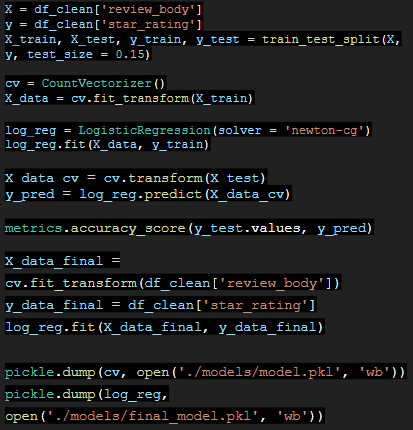

- In this code, we can see how it splits the Amazon review data into train/test. Then it trains a logistic regression classifier, and tests it by predicting and evaluating the accuracy score. Afterwards, it retrains on the entire dataset for production, saving both the vectorizer and the trained model using pickle.

- This prior work differs heavily from from our implementation for training our model, where we used other techniques, such as the use of baseline popularity, Jaccard, TF-IDF, and NCF. 

- This shows how the task of predicting the star rating of Amazon reviews can be and has been implemented in several different ways.


Abhishek Chatterjee’s Code:

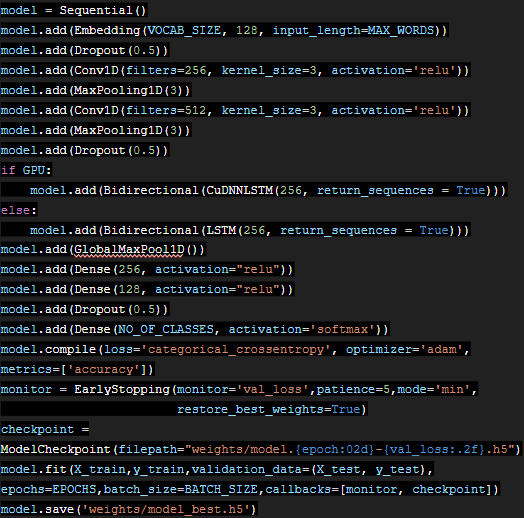

- In this code, we see the model being instantiated by the Keras function Sequential(), and that model is trained by adding layers one after another, creating a straightforward flow of data through the network. We see this in the code, where it adds embedding, feature extraction, bidirectional Long Short-Term Memory (LSTM), and other features.

- This also differs from our code. While we use baseline popularity, Jaccard, TF-IDF, and NCF, this code instead makes use of Convolutional Neural Networks, Bidirectional LSTM, Global Max Pooling, Dense neural layers, and Softmax classification.

- Once again shows how versatile the solutions to this problem can be.

    In our approach to the assignment, we made use of Neural Collaborative Filtering, which is a recommendation system that uses neural networks to model user-item interactions. This system can also be used in other tasks, as seen in Mohsina Bilal’s movie recommendation system. Based on a user’s ratings of movies, her model aims to predict what movies that user would enjoy watching, and thus recommend it to them. She achieves this through the use of item-based neural collaborative filtering, training the neural network on embedding of users and items, and then giving suggestions comparable to items that the given user has rated highly. Mohsina Bilal’s model had a hit rate of 0.89, showing that NCF is effective for recommendation systems.
---
3. How do your results match or differ from what has been reported in related work?

    For the most part, our results differ from what has been reported in related work by quite a bit. Building a recommender system based on Amazon reviews has been done many times before. Thomas Moesl effectively accomplishes the same task, where he builds a recommender system on data with a positive rating bias. In his system, his highest precision@K he achieved was 0.565, which towers over our score of 0.0041. Even if Moesl’s performance was higher than expected, our model’s precision is noticeably lower than what is expected of a typical recommender system, not just ones based on reviews. In contrast, functional recommender systems typically reach precision@K values much higher. This gap highlights that our system is not yet capturing meaningful user-item preference patterns and requires significant redesign or debugging before it can perform at expected levels.
---
References:
- Customer Reviews sentiment Analysis by Deniz Bilgin 
https://huggingface.co/dnzblgn/Sentiment-Analysis-Customer-Reviews

- Amazon Review Generator by Amritesh Chandra
https://huggingface.co/RSPRIMES1234/Amazon-Review-Generator-T5

- Amazon Review Rating Prediction by Pallavraj Sahoo
https://github.com/pallavrajsahoo/Amazon-Review-Rating-Prediction

- Rate Prediction using Amazon Review Dataset by Abhishek Chatterjee
	https://github.com/imdeepmind/RatePrediction

- Movie Recommendation System using Neural Collaborative Filtering by Mohsina Bilal
https://github.com/mohsina-bilal/Movie-Recommendations

- Product Recommendation System For Amazon by Thomas Moesl
	https://github.com/tmoesl/product-recommendation-system
